In [33]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import calendar
from scipy.stats import chi2_contingency

In [2]:
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
import sys
import os

os.chdir(sys.path[3])

In [6]:
raw_data = pd.read_csv(r'data/process/new_data.csv', skiprows=[1, 2]).reset_index()

In [ ]:
# Just for presentation
pd.read_csv(r'data/process/new_data.csv', skiprows=[2]).reset_index()


The questions we are going to use for the following model are stored in the cols variable. Q8 (What type of lock did you use to secure your bicycle? - Selected Choice) has been removed since it includes 951 Nun Values (that means 47% of participants didn't answer that question). The rest of the filtered questions have been removed since I thought they were irrelevant.

In [7]:
cols = ['index', 'Q2', 'Q4', 'Q5', 'Q6', 'Q7', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q17']

In [9]:
raw_features = raw_data[cols]

The code discards participants who answer more than three null questions

In [10]:
filtered_nun = raw_features[raw_features.count(axis=1) > 3]

In [10]:
for col in cols[1:]:
    print(filtered_nun.groupby(by=col, dropna=False).count()['index'])

Q2
A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)      25
Entire bicycle (i.e., frame and components)                                             1826
NaN                                                                                       15
Name: index, dtype: int64
Q4
2017                    45
2018                    54
2019                   262
2020                   325
2021                   695
2022                   159
Don’t know/not sure      7
NaN                    319
Name: index, dtype: int64
Q5
April                  163
August                 145
December                85
Don’t know/not sure    131
February                88
January                 97
July                   137
June                   281
March                  116
May                    264
November                94
October                127
September              134
NaN                      4
Name: index, dtype: int64
Q6
Afternoon (12:00-17:59)    362
Don’t 

### Missing Values

First, a table is created, sorted from the question with the least NuNs to the question with the most NuNs

In [11]:
temp_dic = {'col_q': [], 'nun_count': []}
for col in cols[1:]:
    temp_groupby = filtered_nun.groupby(by=col, dropna=False).count()['index']
    temp_dic['col_q'].append(temp_groupby.index.name)
    temp_dic['nun_count'].append(temp_groupby[[np.nan]][0])
df_col_q_nun_count = DataFrame(temp_dic)
what_to_deal_first = df_col_q_nun_count.sort_values(by='nun_count')
what_to_deal_first

col_q  nun_count
2     Q5          4
4     Q7          8
3     Q6         11
0     Q2         15
9    Q13         26
5     Q9         28
6    Q10         28
7    Q11         28
8    Q12         29
12   Q17         42
11   Q15         68
10   Q14         69
1     Q4        319

Encode the answers to the questions

In [12]:
encode_str = "encode_"
cols_encode = {col: encode_str + col for col in cols[1:]}

 Some columns should have manual encoding

In [13]:
manual_encoding = ['Q4', 'Q5', 'Q6', 'Q7', 'Q13']
q4_dic = {'2022': 6,
          '2021': 5,
          '2020': 4,
          '2019': 3,
          '2018': 2,
          '2017': 1,
          'Don’t know/not sure': 0}
filtered_nun[encode_str + 'Q4'] = filtered_nun['Q4'].replace(q4_dic).fillna(-1).astype(int)

C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\1933532783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q4'] = filtered_nun['Q4'].replace(q4_dic).fillna(-1).astype(int)


In [14]:
q5_dic = {month: index for index, month in enumerate(calendar.month_name) if month}
q5_dic['Don’t know/not sure'] = 0
filtered_nun[encode_str + 'Q5'] = filtered_nun['Q5'].replace(q5_dic, regex=True).fillna(-1).astype(int)

C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\4233636217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q5'] = filtered_nun['Q5'].replace(q5_dic, regex=True).fillna(-1).astype(int)


In [18]:
q6_dic = {'Evening (18:00-23:59)': 3,
          'Morning (06:00-11:59)': 1,
          'Afternoon (12:00-17:59)': 2,
          'Overnight (00:00-05:59)': 4,
          'Don’t know/not sure': 0}
filtered_nun[encode_str + 'Q6'] = filtered_nun['Q6'].replace(q6_dic).fillna(-1).astype(int)

C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\3458403864.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q6'] = filtered_nun['Q6'].replace(q6_dic).fillna(-1).astype(int)


In [15]:
q7_dic = {'Yes, frame locked to a fixed structure (e.g., bike rack) ': 3,
          'No, unlocked ': 1,
          'Yes, locked one or more wheels (i.e., bike locked to itself) ': 2,
          'Don’t know/not sure': 0}
filtered_nun[encode_str + 'Q7'] = filtered_nun['Q7'].replace(q7_dic).fillna(-1).astype(int)


C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\2873978644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q7'] = filtered_nun['Q7'].replace(q7_dic).fillna(-1).astype(int)


In [16]:
q13_dic = {'$7000 or more ': 8,
           '$4000-6999       ': 7,
           '$2000-3999      ': 6,
           '$1000-$1999 ': 5,
           '$500-$999 ': 4,
           '$250-$499 ': 3,
           'Less than $250 ': 2,
           'Don’t know/not sure ': 0, 'I prefer to not answer': 1
           }
filtered_nun[encode_str + 'Q13'] = filtered_nun['Q13'].replace(q13_dic).fillna(-1).astype(int)


C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\2495687643.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q13'] = filtered_nun['Q13'].replace(q13_dic).fillna(-1).astype(int)


Automatic Encoding

In [19]:
auto_encoding = cols_encode.copy()
[auto_encoding.pop(key) for key in manual_encoding]
filtered_nun[list(auto_encoding.values())] = filtered_nun[list(auto_encoding.keys())].apply(
    lambda x: x.astype('category').cat.codes)
for col in cols_encode.items():
    col = list(col)
    print(filtered_nun[col].apply(lambda x: x.drop_duplicates()))

                                                   Q2  encode_Q2
0   A major bicycle part necessary for riding (i.e...          0
2        Entire bicycle (i.e., frame and components)           1
38                                                NaN         -1
                      Q4  encode_Q4
0                   2019          3
2                   2022          6
3                   2017          1
5                   2020          4
6                   2021          5
7                    NaN         -1
55                  2018          2
411  Don’t know/not sure          0
                     Q5  encode_Q5
0   Don’t know/not sure          0
2                March           3
3                  May           5
6                April           4
16            December          12
23            November          11
29                July           7
35             October          10
37            February           2
39              August           8
43                June         

C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\3652104360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[list(auto_encoding.values())] = filtered_nun[list(auto_encoding.keys())].apply(


# Sol 1

The NuNs of the question with the fewest NuNs will be replaced with the most popular answer

In [17]:
sol1 = filtered_nun.copy()
min_nun = cols_encode[what_to_deal_first.iloc[0]['col_q']]
print("The question with the fewest NuN values is {} ".format(min_nun))
replace_nun = filtered_nun.groupby(by=min_nun, dropna=False).count()['index'].idxmax()
print("the most popular answer for {} is {} ".format(min_nun, replace_nun))
sol1[min_nun] = sol1[min_nun].replace(-1, replace_nun)
sol1

The question with the fewest NuN values is encode_Q5 
the most popular answer for encode_Q5 is 7 


index                                                 Q2    Q4  \
0         0  A major bicycle part necessary for riding (i.e...  2019   
2         2       Entire bicycle (i.e., frame and components)   2022   
3         3       Entire bicycle (i.e., frame and components)   2017   
4         4       Entire bicycle (i.e., frame and components)   2022   
5         5       Entire bicycle (i.e., frame and components)   2020   
...     ...                                                ...   ...   
2019   2019       Entire bicycle (i.e., frame and components)   2022   
2020   2020       Entire bicycle (i.e., frame and components)    NaN   
2021   2021       Entire bicycle (i.e., frame and components)    NaN   
2022   2022       Entire bicycle (i.e., frame and components)   2017   
2024   2024       Entire bicycle (i.e., frame and components)   2022   

                       Q5                       Q6  \
0     Don’t know/not sure    Evening (18:00-23:59)   
2                  March     Morning (06:00-11:59)   
3                    May     Evening (18:00-23:59)   
4                  March   Afternoon (12:00-17:59)   
5     Don’t know/not sure    Evening (18:00-23:59)   
...                   ...                      ...   
2019               March   Overnight (00:00-05:59)   
2020               March     Morning (06:00-11:59)   
2021                 May     Evening (18:00-23:59)   
2022  Don’t know/not sure  Afternoon (12:00-17:59)   
2024             January     Evening (18:00-23:59)   

                                                     Q7  \
0     Yes, frame locked to a fixed structure (e.g., ...   
2     Yes, frame locked to a fixed structure (e.g., ...   
3     Yes, locked one or more wheels (i.e., bike loc...   
4     Yes, frame locked to a fixed structure (e.g., ...   
5                                         No, unlocked    
...                                                 ...   
2019                                      No, unlocked    
2020                                      No, unlocked    
2021                                      No, unlocked    
2022  Yes, frame locked to a fixed structure (e.g., ...   
2024  Yes, frame locked to a fixed structure (e.g., ...   

                                                     Q9   Q10  \
0                                    Outdoor bike rack    No    
2                               Other (please specify):   No    
3                                                   NaN   NaN   
4                                    Outdoor bike rack   Yes    
5                                    Outdoor bike rack    No    
...                                                 ...   ...   
2019  Outside in the yard or on a balcony, porch, or...   No    
2020                              Inside a shed/garage    No    
2021                              Inside a shed/garage    No    
2022                            Other (please specify):   No    
2024                            Other (please specify):   No    

                                                    Q11   Q12  ... encode_Q6  \
0                            I did not report the theft   No   ...         2   
2     The police ,A bicycle registry/recovery system...   No   ...         3   
3                                                   NaN   NaN  ...         2   
4                                           The police   Yes   ...         0   
5     The police ,A bicycle registry/recovery system...   No   ...         2   
...                                                 ...   ...  ...       ...   
2019                                        The police   Yes   ...         4   
2020                                        The police    No   ...         3   
2021  The police ,A bicycle registry/recovery system...   No   ...         2   
2022                                        The police    No   ...         0   
2024  The police ,A bicycle registry/recovery system...  Yes   ...         2   

     encode_Q7 encode_Q9 encode_Q10  enco

By using a random forest tree, impute the missing values in the rest of the columns

In [19]:
clf = RandomForestClassifier(random_state=0)
x_columns = [min_nun]
for col in what_to_deal_first['col_q'][1:]:
    cur_field = cols_encode[col]
    print(col)
    x_columns.append(cur_field)
    data = sol1.loc[filtered_nun[cur_field] > -1, x_columns]
    X = data[x_columns[:-1]].to_numpy()
    y = data[x_columns[-1]].to_numpy()
    clf.fit(X, y)
    print(clf.score(X, y))
    data_to_predict = sol1.loc[filtered_nun[cur_field] == -1, x_columns[:-1]].to_numpy()
    sol1.loc[filtered_nun[cur_field] == -1, cur_field] = clf.predict(data_to_predict)

Q7
0.5220667384284177
Q6
0.4123989218328841
Q2
0.9870340356564019
Q13
0.3858695652173913
Q9
0.6387377584330794
Q10
0.8781284004352558
Q11
0.8824809575625681
Q12
0.9695155144256941
Q17
0.993421052631579
Q15
0.9766407119021134
Q14
1.0
Q4
0.9903038138332256


## Sol 2

In [20]:
sol2 = filtered_nun.copy()
clf = RandomForestClassifier(random_state=0)
for col in what_to_deal_first['col_q']:
    print(col)
    y_col = cols_encode[col]
    # Get only encode columns from the table
    pre_filter = sol2[list(cols_encode.values())]

    # get only rows with Nun (-1) in current cul
    pre_x = pre_filter[pre_filter[y_col] == -1].drop(columns=y_col)
    # Find columns with Nun values. That columns would not consider features
    res = pre_x[pre_x == -1].any()
    no_features_list = list(res[res == True].index)
    print('number of features are:{}'.format(len(cols) - 2 - len(no_features_list)))
    x_predict = pre_x.drop(columns=no_features_list)
    features_labels = pre_filter.drop(columns=no_features_list)

    # Build the data for the prediction
    xy = features_labels[~features_labels[features_labels == -1].any(axis=1)]
    x = xy.drop(columns=y_col).to_numpy()
    y = xy[y_col].to_numpy()

    clf.fit(x, y)
    print(clf.score(x, y))
    sol2.loc[sol2[y_col] == -1, y_col] = clf.predict(x_predict)
sol2

Q5
number of features are:10
0.8723041997729852


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Q7
number of features are:3
0.5547540983606557
Q6
number of features are:3
0.41630434782608694
Q2
number of features are:9
1.0
Q13
number of features are:4
0.3858695652173913
Q9
number of features are:5


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6376496191512514
Q10
number of features are:6
0.8775843307943417
Q11
number of features are:7


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.8841131664853101
Q12
number of features are:8
0.9695155144256941
Q17
number of features are:9


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.9928728070175439
Q15
number of features are:10
0.9766407119021134
Q14
number of features are:11


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


1.0
Q4
number of features are:12
0.9903038138332256


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


index                                                 Q2    Q4  \
0         0  A major bicycle part necessary for riding (i.e...  2019   
2         2       Entire bicycle (i.e., frame and components)   2022   
3         3       Entire bicycle (i.e., frame and components)   2017   
4         4       Entire bicycle (i.e., frame and components)   2022   
5         5       Entire bicycle (i.e., frame and components)   2020   
...     ...                                                ...   ...   
2019   2019       Entire bicycle (i.e., frame and components)   2022   
2020   2020       Entire bicycle (i.e., frame and components)    NaN   
2021   2021       Entire bicycle (i.e., frame and components)    NaN   
2022   2022       Entire bicycle (i.e., frame and components)   2017   
2024   2024       Entire bicycle (i.e., frame and components)   2022   

                       Q5                       Q6  \
0     Don’t know/not sure    Evening (18:00-23:59)   
2                  March     Morning (06:00-11:59)   
3                    May     Evening (18:00-23:59)   
4                  March   Afternoon (12:00-17:59)   
5     Don’t know/not sure    Evening (18:00-23:59)   
...                   ...                      ...   
2019               March   Overnight (00:00-05:59)   
2020               March     Morning (06:00-11:59)   
2021                 May     Evening (18:00-23:59)   
2022  Don’t know/not sure  Afternoon (12:00-17:59)   
2024             January     Evening (18:00-23:59)   

                                                     Q7  \
0     Yes, frame locked to a fixed structure (e.g., ...   
2     Yes, frame locked to a fixed structure (e.g., ...   
3     Yes, locked one or more wheels (i.e., bike loc...   
4     Yes, frame locked to a fixed structure (e.g., ...   
5                                         No, unlocked    
...                                                 ...   
2019                                      No, unlocked    
2020                                      No, unlocked    
2021                                      No, unlocked    
2022  Yes, frame locked to a fixed structure (e.g., ...   
2024  Yes, frame locked to a fixed structure (e.g., ...   

                                                     Q9   Q10  \
0                                    Outdoor bike rack    No    
2                               Other (please specify):   No    
3                                                   NaN   NaN   
4                                    Outdoor bike rack   Yes    
5                                    Outdoor bike rack    No    
...                                                 ...   ...   
2019  Outside in the yard or on a balcony, porch, or...   No    
2020                              Inside a shed/garage    No    
2021                              Inside a shed/garage    No    
2022                            Other (please specify):   No    
2024                            Other (please specify):   No    

                                                    Q11   Q12  ... encode_Q13  \
0                            I did not report the theft   No   ...          3   
2     The police ,A bicycle registry/recovery system...   No   ...          5   
3                                                   NaN   NaN  ...          6   
4                                           The police   Yes   ...          6   
5     The police ,A bicycle registry/recovery system...   No   ...          4   
...                                                 ...   ...  ...        ...   
2019                                        The police   Yes   ...          3   
2020                                        The police    No   ...          5   
2021  The police ,A bicycle registry/recovery system...   No   ...          6   
2022                                        The police    No   ...          6   
2024  The police ,A bicycle registry/recovery system...  Yes   ...          8   

     encode_Q2 encode_Q9 enco

## Decision Tree for Recovery

In [21]:
recovery_col = 'Q18'
recovery_col_encode = "encode_" + recovery_col
sol2[recovery_col] = raw_data[recovery_col]

In [22]:
print(sol2.groupby(by=recovery_col, dropna=False).count()['index'])

Q18
No                             1555
Yes (including if damaged)      281
NaN                              30
Name: index, dtype: int64


In [ ]:
# Rows without recovery information should be discarded
pre_dt = sol2[sol2[recovery_col].notna()]
# Encode recovery (0 or 1)
pre_dt[recovery_col_encode] = pre_dt[recovery_col].astype('category').cat.codes
pre_dt

Training the tree

In [77]:
clf = DecisionTreeClassifier(random_state=0)

In [78]:
x_tree = pre_dt[list(cols_encode.values())].to_numpy()
y_tree = pre_dt[recovery_col_encode].to_numpy()


In [81]:
dt = clf.fit(x_tree, y_tree)

In [80]:
x_tree.shape

(1836, 13)

In [86]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(dt, prefit=True)
X_new = model.transform(x_tree)
new_tree = clf.fit(X_new, y_tree)

DecisionTreeClassifier(random_state=0)

In [90]:
pre_dt

index                                                 Q2    Q4  \
0         0  A major bicycle part necessary for riding (i.e...  2019   
2         2       Entire bicycle (i.e., frame and components)   2022   
4         4       Entire bicycle (i.e., frame and components)   2022   
5         5       Entire bicycle (i.e., frame and components)   2020   
6         6       Entire bicycle (i.e., frame and components)   2021   
...     ...                                                ...   ...   
2019   2019       Entire bicycle (i.e., frame and components)   2022   
2020   2020       Entire bicycle (i.e., frame and components)    NaN   
2021   2021       Entire bicycle (i.e., frame and components)    NaN   
2022   2022       Entire bicycle (i.e., frame and components)   2017   
2024   2024       Entire bicycle (i.e., frame and components)   2022   

                       Q5                       Q6  \
0     Don’t know/not sure    Evening (18:00-23:59)   
2                  March     Morning (06:00-11:59)   
4                  March   Afternoon (12:00-17:59)   
5     Don’t know/not sure    Evening (18:00-23:59)   
6                  April   Overnight (00:00-05:59)   
...                   ...                      ...   
2019               March   Overnight (00:00-05:59)   
2020               March     Morning (06:00-11:59)   
2021                 May     Evening (18:00-23:59)   
2022  Don’t know/not sure  Afternoon (12:00-17:59)   
2024             January     Evening (18:00-23:59)   

                                                     Q7  \
0     Yes, frame locked to a fixed structure (e.g., ...   
2     Yes, frame locked to a fixed structure (e.g., ...   
4     Yes, frame locked to a fixed structure (e.g., ...   
5                                         No, unlocked    
6                                         No, unlocked    
...                                                 ...   
2019                                      No, unlocked    
2020                                      No, unlocked    
2021                                      No, unlocked    
2022  Yes, frame locked to a fixed structure (e.g., ...   
2024  Yes, frame locked to a fixed structure (e.g., ...   

                                                     Q9   Q10  \
0                                    Outdoor bike rack    No    
2                               Other (please specify):   No    
4                                    Outdoor bike rack   Yes    
5                                    Outdoor bike rack    No    
6                                 Inside a shed/garage    No    
...                                                 ...   ...   
2019  Outside in the yard or on a balcony, porch, or...   No    
2020                              Inside a shed/garage    No    
2021                              Inside a shed/garage    No    
2022                            Other (please specify):   No    
2024                            Other (please specify):   No    

                                                    Q11   Q12  ... encode_Q9  \
0                            I did not report the theft   No   ...         7   
2     The police ,A bicycle registry/recovery system...   No   ...         6   
4                                           The police   Yes   ...         7   
5     The police ,A bicycle registry/recovery system...   No   ...         7   
6     The police ,A bicycle registry/recovery system...  Yes   ...         4   
...                                                 ...   ...  ...       ...   
2019                                        The police   Yes   ...         8   
2020                                        The police    No   ...         4   
2021  The police ,A bicycle registry/recovery system...   No   ...         4   
2022                                        The police    No   ...         6   
2024  The police ,A bicycle registry/recovery system...  Yes   ...         6   

     encode_Q10 encode_Q11 encode_Q12  en

In [ ]:
# Tree Analysis

In [88]:
print(clf.score(X_new, y_tree))
print(clf.feature_importances_)

0.9912854030501089
[0.09551576 0.21937241 0.11700164 0.1521929  0.17068405 0.07805603
 0.16717722]


In [98]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=500)
tree.plot_tree(clf,
               feature_names=cols[1:],

               class_names=['not_recovered', 'recovered'],
               filled=True)
fig.savefig('imagename.pdf')
# feature_names=cols[ 'encode_Q4', 'encode_Q5', 'encode_Q6','encode_Q9', 'encode_Q11', 'encode_Q13', 'encode_Q15'],

In [100]:

fig, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=500)
tree.plot_tree(clf,
               class_names=['not_recovered', 'recovered'],
               filled=True)
fig.savefig('python/notebooks/new_tree.pdf')

# general analysis on recovery

In [23]:
recovery = pre_dt[pre_dt['encode_Q18'] == 1]
not_recovery = pre_dt[pre_dt['encode_Q18'] == 0]


encode_Q2
encode_Q4
encode_Q5
encode_Q6
encode_Q7
encode_Q9
encode_Q10
encode_Q11
encode_Q12
encode_Q13
encode_Q14
encode_Q15
encode_Q17


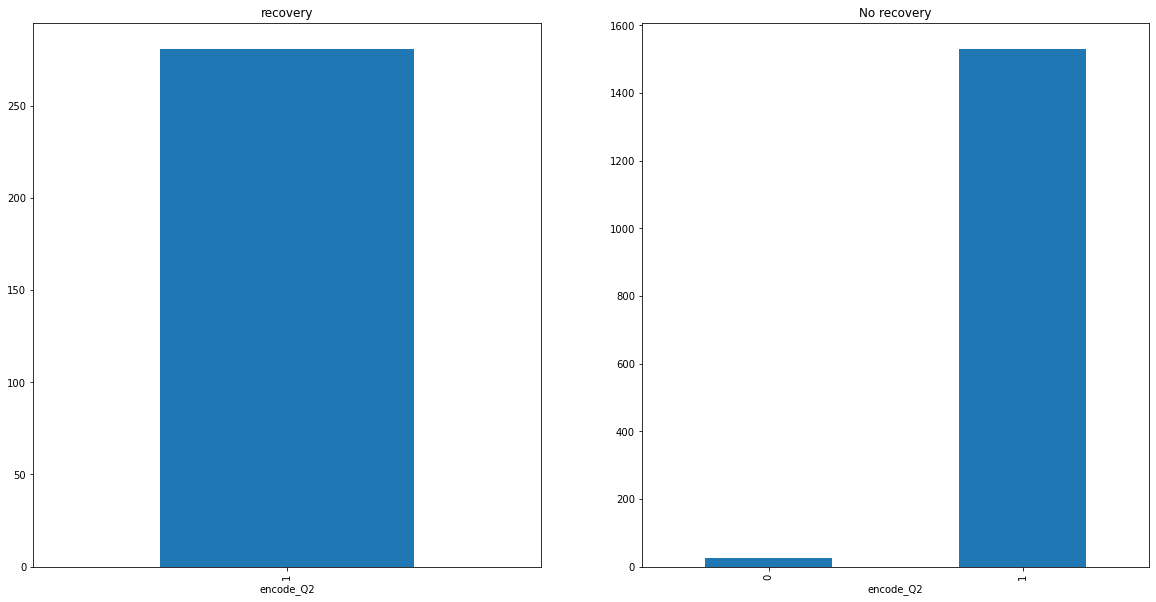

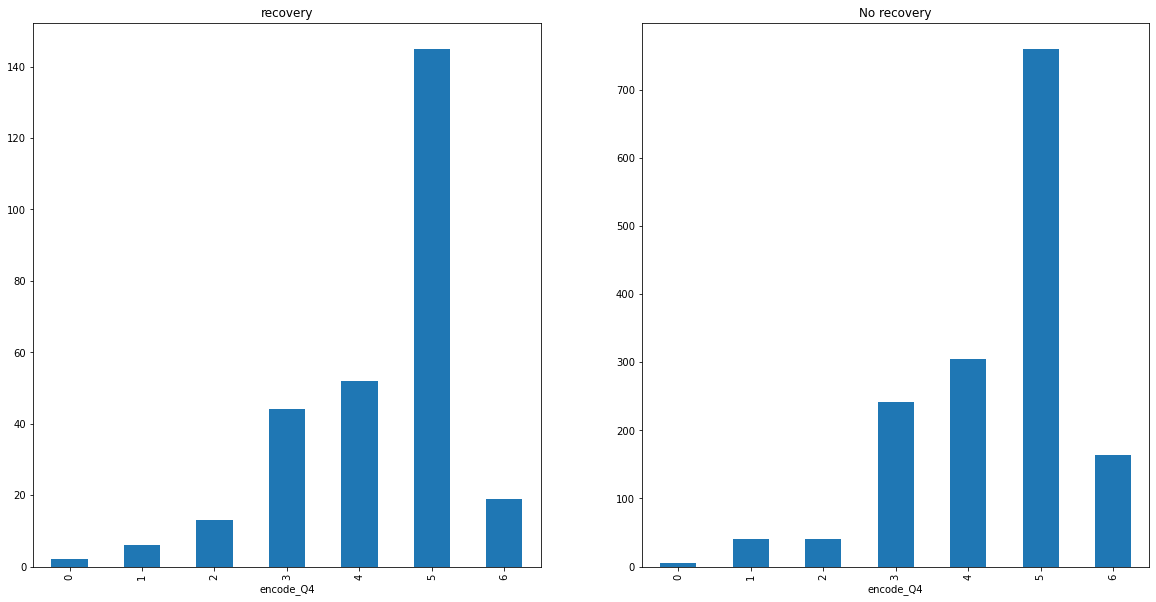

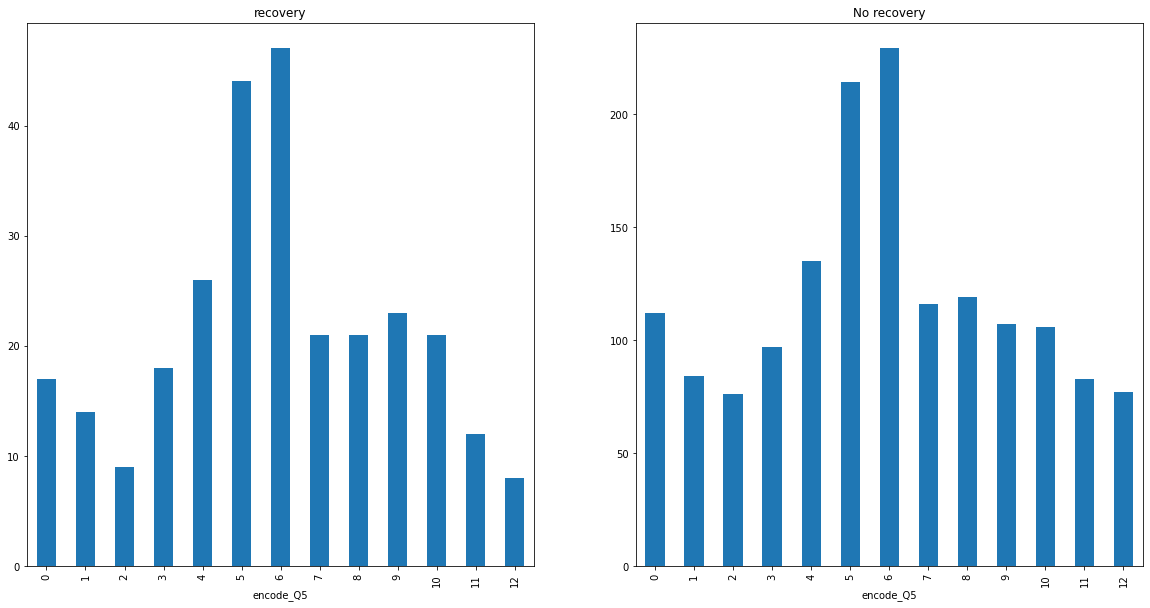

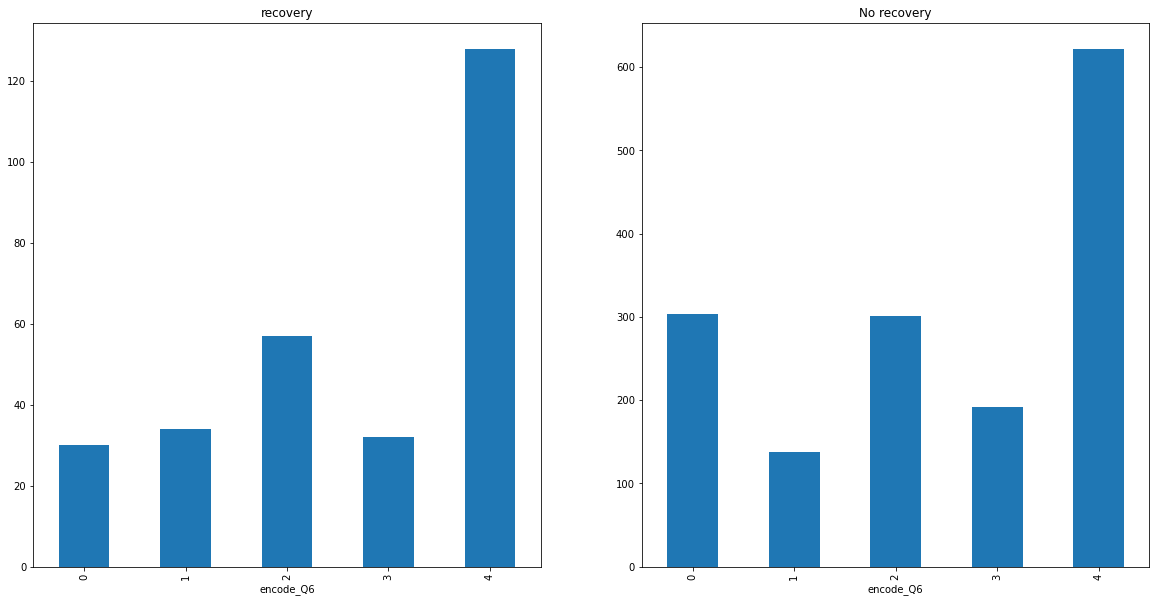

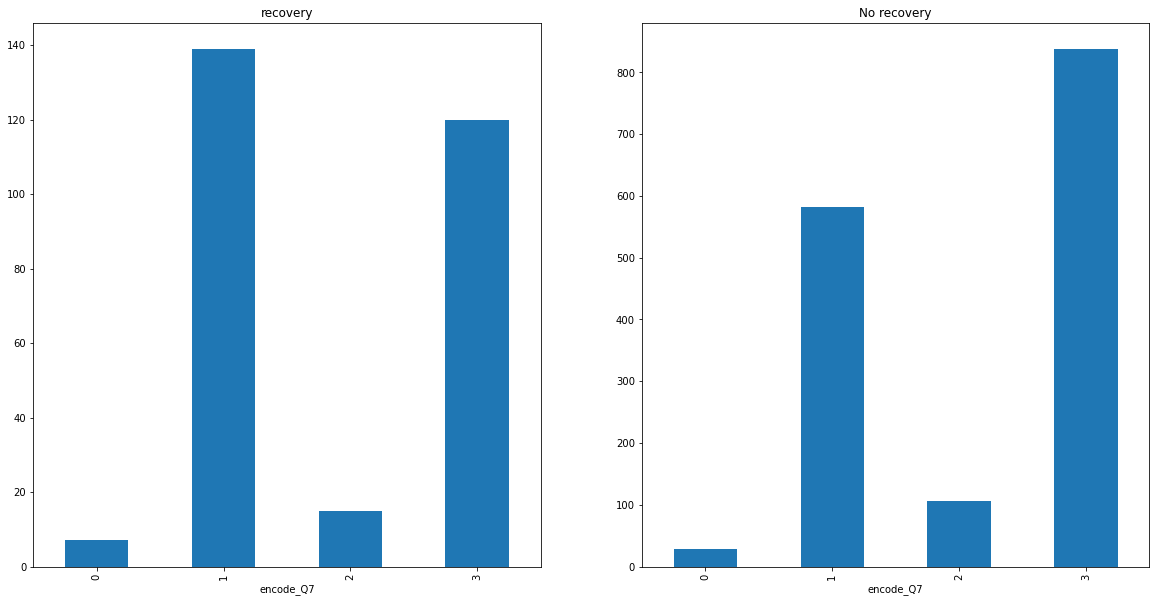

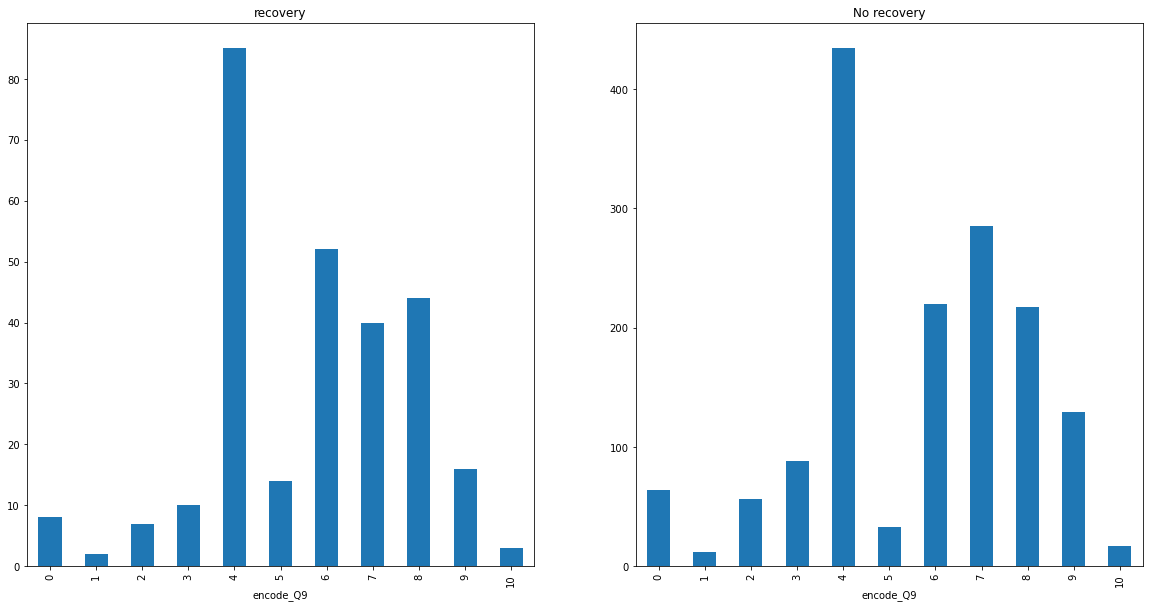

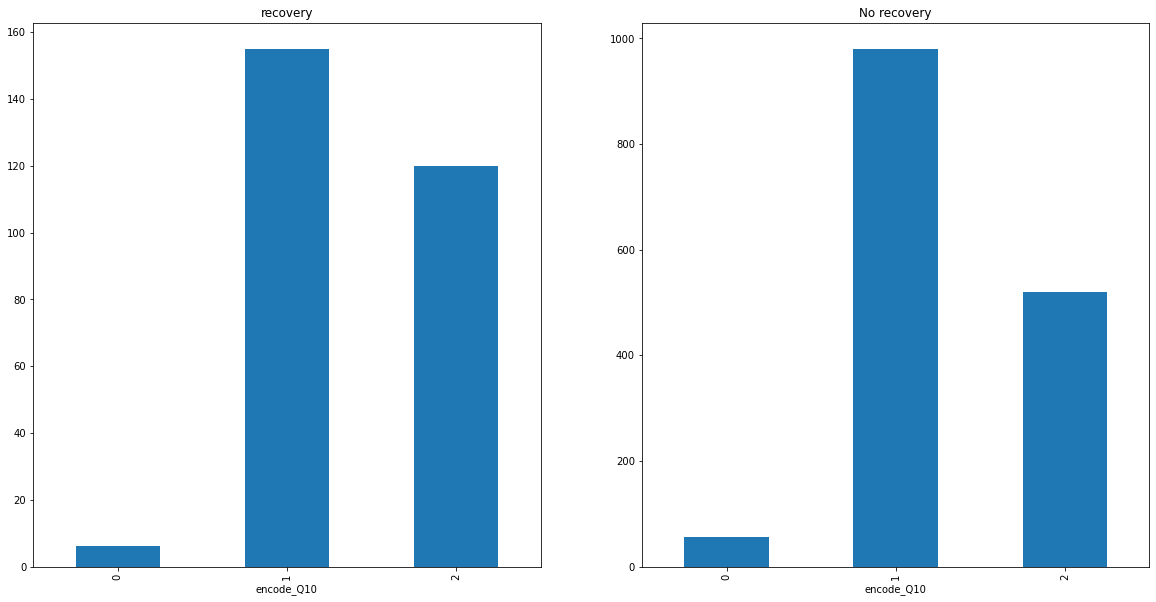

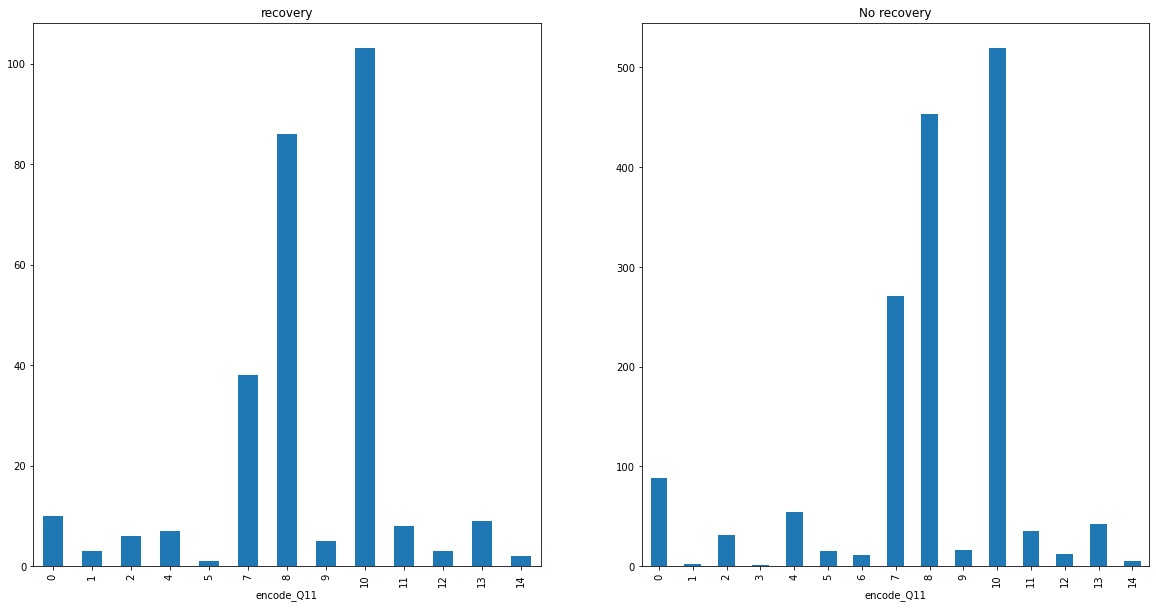

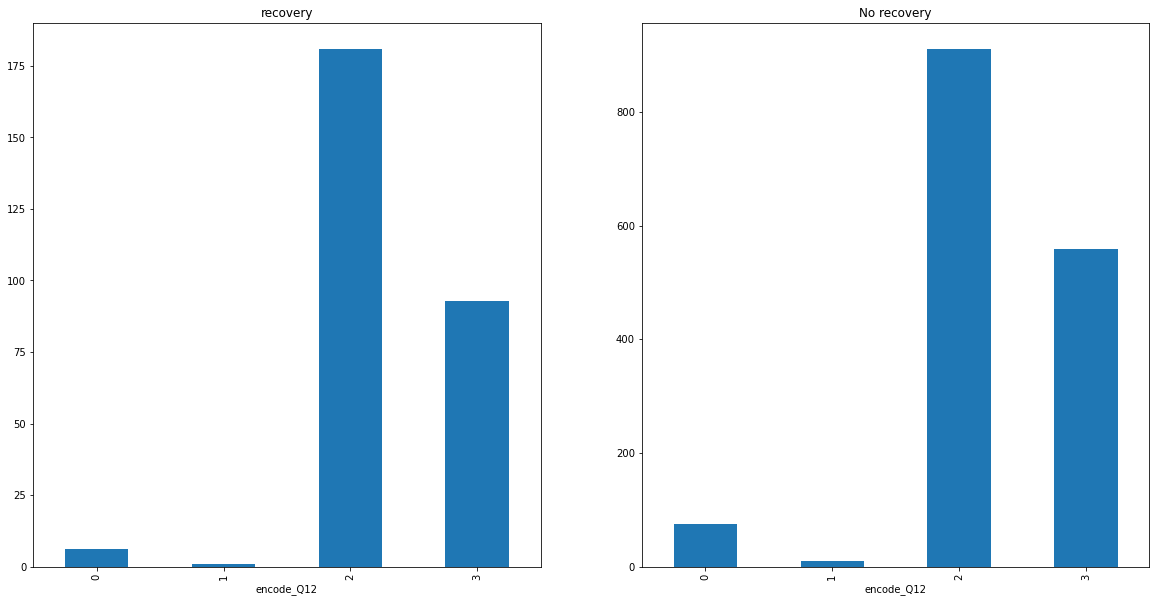

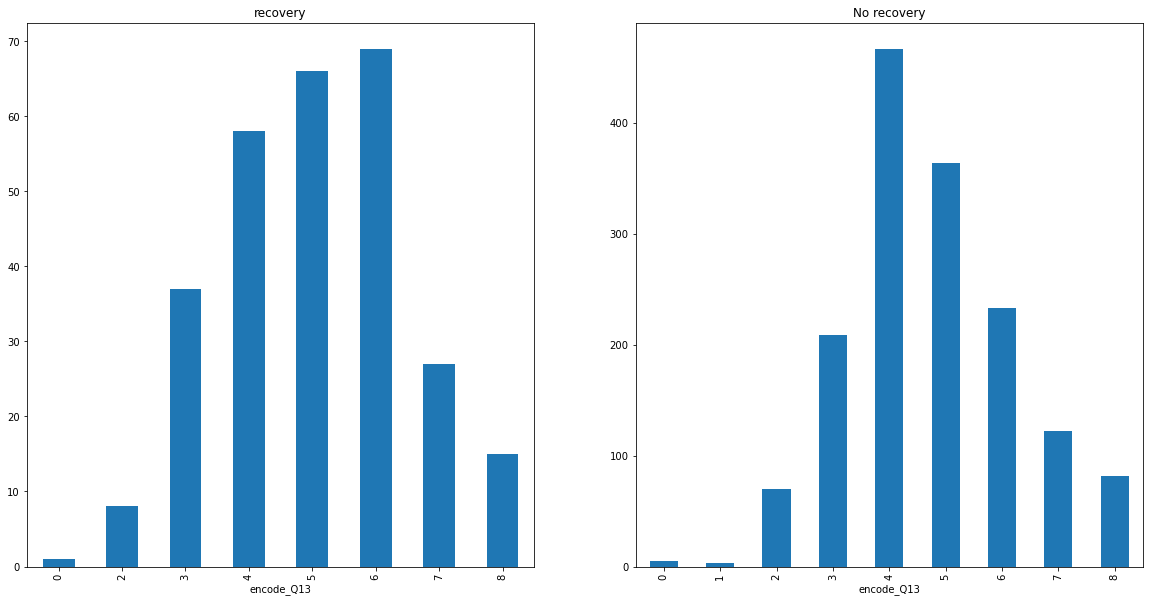

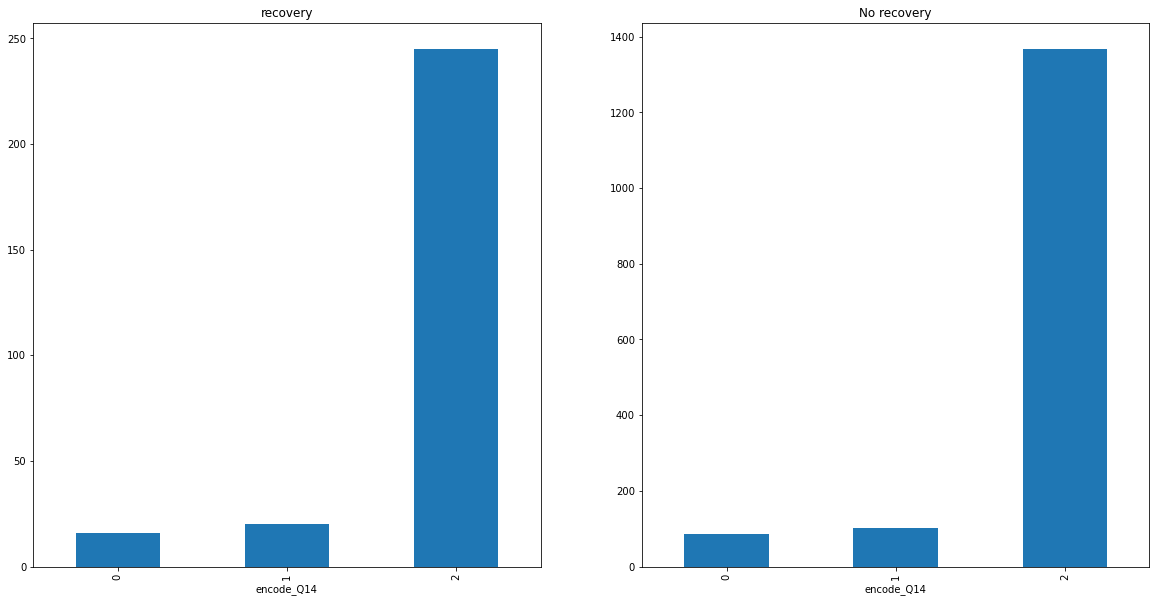

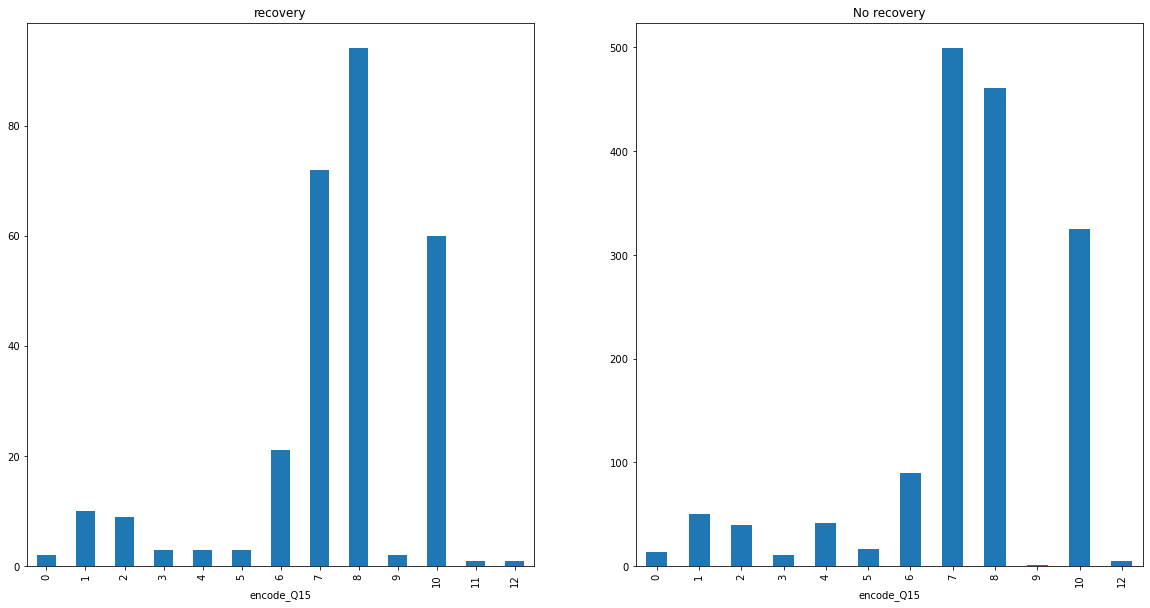

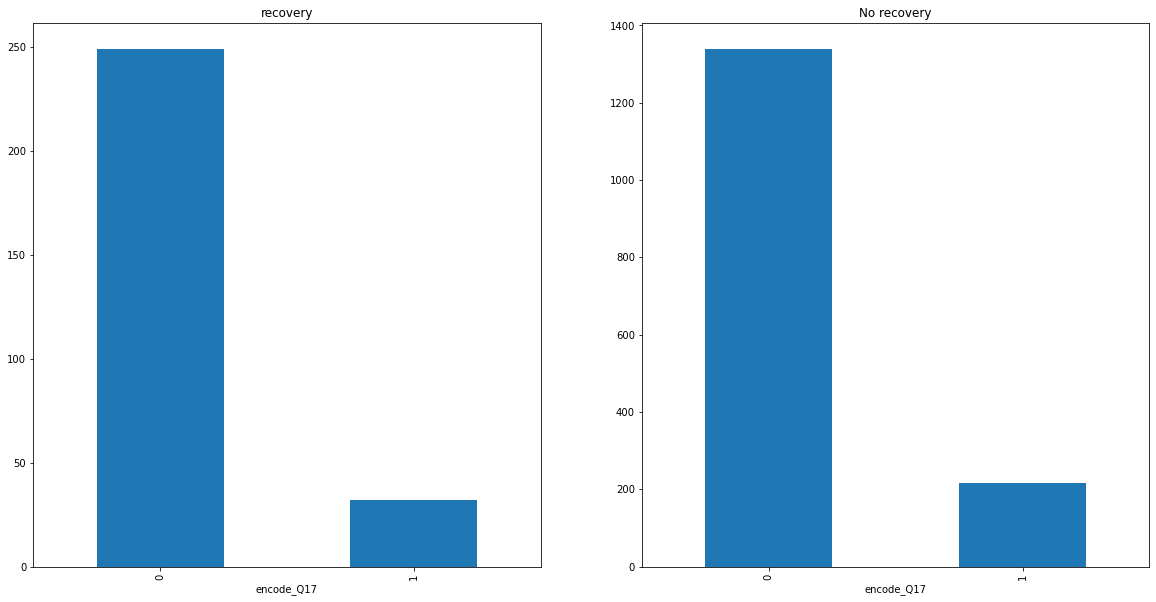

In [110]:
for encode_col in cols_encode.values():
    print(encode_col)
    figure(figsize=(20, 10))
    recovery.groupby(by=encode_col).count()['index'].plot.bar(ax=plt.subplot(1, 2, 1),title= 'recovery')
    not_recovery.groupby(by=encode_col).count()['index'].plot.bar(ax=plt.subplot(1, 2, 2), title= 'No recovery')


### Recovery in the same and different place

Getting the data from the relevant files

In [25]:
## get location of stolen and recover places and check if it is the same
def compare_places(row):
    stolen,rec= row['stolen_bikes_place'],row['recover_bikes_place']
    stolen_list, rec_list = stolen.split(','),rec.split(',')
    # if one of the places not has information about the city compare the states
    if stolen_list[0]=='' or rec_list[0]=='':
        if stolen_list[1] ==rec_list[1]:
            return 'same'
    else:
        if stolen_list[0] ==rec_list[0]:
            return 'same'
    return 'diff'

In [26]:
rec_file = pd.read_csv(r'data/process/res_with_geo_loc_rec.csv')
rec_file['is_same'] = rec_file[['stolen_bikes_place','recover_bikes_place']].apply(compare_places,axis=1)
rec_file

index  Unnamed: 0  Unnamed: 0.1        StartDate          EndDate  \
0        4           2             4   4/22/2022 9:08   4/22/2022 9:24   
1       12          10            12  4/22/2022 11:59  4/22/2022 12:06   
2       15          12            15  4/22/2022 15:46  4/22/2022 15:54   
3       18          15            18  4/22/2022 18:11  4/22/2022 18:17   
4       20          17            20  4/23/2022 18:00  4/23/2022 18:14   
..     ...         ...           ...              ...              ...   
272   1976        1781          1976    6/1/2022 9:10   6/1/2022 10:44   
273   1986        1791          1986   6/1/2022 21:01   6/1/2022 21:08   
274   1988        1793          1988    6/2/2022 6:04    6/2/2022 6:09   
275   2011        1814          2011   6/4/2022 12:30   6/5/2022 14:34   
276   2017        1820          2017    6/6/2022 9:41    6/6/2022 9:48   

         Status       IPAddress  Progress  Duration (in seconds)  Finished  \
0    IP Address     24.52.45.71       100                    968      True   
1    IP Address   172.58.46.144       100                    447      True   
2    IP Address   172.58.24.250       100                    431      True   
3    IP Address    23.17.63.224       100                    365      True   
4    IP Address   72.198.57.234       100                    834      True   
..          ...             ...       ...                    ...       ...   
272  IP Address   98.171.142.89       100                   5626      True   
273  IP Address  174.194.202.64       100                    378      True   
274  IP Address  104.62.161.218       100                    328      True   
275  IP Address    98.60.66.166       100                  93867      True   
276  IP Address    98.173.167.2       100                    458      True   

     ...         lat        lon   score            stolen_bikes_place  \
0    ... -122.329450  47.603570  100.00        Seattle,Washington,USA   
1    ... -122.329450  47.603570  100.00        Seattle,Washington,USA   
2    ... -117.161710  32.715680  100.00      San Diego,California,USA   
3    ... -114.057141  51.045113  100.00           Calgary,Alberta,CAN   
4    ...  -97.521070  35.472030  100.00    Oklahoma City,Oklahoma,USA   
..   ...         ...        ...     ...                           ...   
272  ... -119.699050  34.419380  100.00  Santa Barbara,California,USA   
273  ... -119.699050  34.419380  100.00  Santa Barbara,California,USA   
274  ...  -90.077750  29.953700  100.00     New Orleans,Louisiana,USA   
275  ... -106.649050  35.084230  100.00    Albuquerque,New Mexico,USA   
276  ... -119.699050  34.419380   96.62  Santa Barbara,California,USA   

     country     lat_rec    lon_rec  score_rec           recover_bikes_place  \
0        USA -122.329450  47.603570      100.0               ,Washington,USA   
1        USA -122.329450  47.603570       84.6        Seattle,Washington,USA   
2        USA -117.161710  32.715680      100.0      San Diego,California,USA   
3        CAN -114.057141  51.045113      100.0           Calgary,Alberta,CAN   
4        USA  -97.521070  35.472030      100.0    Oklahoma City,Oklahoma,USA   
..       ...         ...        ...        ...                           ...   
272      USA -119.699050  34.419380      100.0  Santa Barbara,California,USA   
273      USA -119.699050  34.419380      100.0  Santa Barbara,California,USA   
274      USA  -90.077750  29.953700      100.0     New Orleans,Louisiana,USA   
275      USA -106.649050  35.084230      100.0    Albuquerque,New Mexico,USA   
276      USA -119.292320  34.280820      100.0        Ventura,California,USA   

    is_same  
0      same  
1      same  
2      same  
3      same  
4      same  
..      ...  
272    same  
273    same  
274    same  
275    same  
276    diff  

[277 rows x 87 columns]

I can add to the recovery file the relevant information that distinguishes between the same location and a different location of theft and recovery using ResponseId and index columns.

In [27]:
is_same = 'is_same'
# Add is_same to raw data
raw_data.set_index('ResponseId',inplace=True)
rec_file.set_index('ResponseId',inplace=True)
raw_data[is_same] = rec_file[is_same]


In [28]:
raw_data.set_index('index',inplace=True)
recovery.set_index('index',inplace=True)
recovery[is_same] = raw_data[is_same]
recovery.reset_index(inplace=True)

C:\Users\Achituv\AppData\Local\Temp\ipykernel_28456\388755916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recovery[is_same] = raw_data[is_same]


In [29]:

same = recovery[recovery['is_same'] == 'same']
diff = recovery[recovery['is_same'] == 'diff']
diff

index                                            Q2    Q4  \
5       25  Entire bicycle (i.e., frame and components)   2020   
22     140  Entire bicycle (i.e., frame and components)    NaN   
24     162  Entire bicycle (i.e., frame and components)   2021   
25     166  Entire bicycle (i.e., frame and components)   2021   
28     182  Entire bicycle (i.e., frame and components)   2021   
33     227  Entire bicycle (i.e., frame and components)   2021   
44     295  Entire bicycle (i.e., frame and components)   2021   
46     301  Entire bicycle (i.e., frame and components)   2021   
56     344  Entire bicycle (i.e., frame and components)   2021   
62     375  Entire bicycle (i.e., frame and components)    NaN   
63     379  Entire bicycle (i.e., frame and components)    NaN   
82     495  Entire bicycle (i.e., frame and components)   2021   
83     503  Entire bicycle (i.e., frame and components)   2017   
87     520  Entire bicycle (i.e., frame and components)   2021   
94     567  Entire bicycle (i.e., frame and components)   2019   
98     581  Entire bicycle (i.e., frame and components)    NaN   
103    614  Entire bicycle (i.e., frame and components)   2020   
107    625  Entire bicycle (i.e., frame and components)    NaN   
110    642  Entire bicycle (i.e., frame and components)   2020   
116    667  Entire bicycle (i.e., frame and components)    NaN   
119    695  Entire bicycle (i.e., frame and components)   2019   
125    755  Entire bicycle (i.e., frame and components)    NaN   
127    779  Entire bicycle (i.e., frame and components)   2020   
130    788  Entire bicycle (i.e., frame and components)   2020   
142    842  Entire bicycle (i.e., frame and components)   2021   
143    848  Entire bicycle (i.e., frame and components)   2021   
146    864  Entire bicycle (i.e., frame and components)   2019   
164    963  Entire bicycle (i.e., frame and components)   2019   
167   1002  Entire bicycle (i.e., frame and components)    NaN   
170   1059  Entire bicycle (i.e., frame and components)   2021   
172   1065  Entire bicycle (i.e., frame and components)    NaN   
175   1086  Entire bicycle (i.e., frame and components)   2021   
177   1100  Entire bicycle (i.e., frame and components)   2021   
179   1105  Entire bicycle (i.e., frame and components)   2021   
183   1145  Entire bicycle (i.e., frame and components)   2021   
198   1234  Entire bicycle (i.e., frame and components)   2020   
212   1302  Entire bicycle (i.e., frame and components)   2021   
215   1350  Entire bicycle (i.e., frame and components)   2021   
224   1465  Entire bicycle (i.e., frame and components)   2021   
227   1523  Entire bicycle (i.e., frame and components)   2019   
228   1540  Entire bicycle (i.e., frame and components)   2020   
230   1542  Entire bicycle (i.e., frame and components)   2021   
231   1550  Entire bicycle (i.e., frame and components)   2021   
242   1615  Entire bicycle (i.e., frame and components)   2019   
249   1686  Entire bicycle (i.e., frame and components)   2020   
261   1807  Entire bicycle (i.e., frame and components)   2020   
262   1818  Entire bicycle (i.e., frame and components)   2021   
265   1832  Entire bicycle (i.e., frame and components)   2019   
266   1836  Entire bicycle (i.e., frame and components)   2019   
269   1908  Entire bicycle (i.e., frame and components)   2020   
280   2017  Entire bicycle (i.e., frame and components)    NaN   

                      Q5                       Q6  \
5                 April   Afternoon (12:00-17:59)   
22                April   Overnight (00:00-05:59)   
24                  May       Don’t know/not sure   
25                April     Evening (18:00-23:59)   
28                 June     Morning (06:00-11:59)   
33                  May     Morning (06:00-11:59)   
44                 July   Afternoon (12:00-17:59)   
46                  May     Morning (06:00-11:59)   
56                  May   Overnight (00:00-05:59)   
62                  May   Afternoon (12:00

encode_Q2
encode_Q4
encode_Q5
encode_Q6
encode_Q7
encode_Q9
encode_Q10
encode_Q11
encode_Q12
encode_Q13
encode_Q14
encode_Q15
encode_Q17


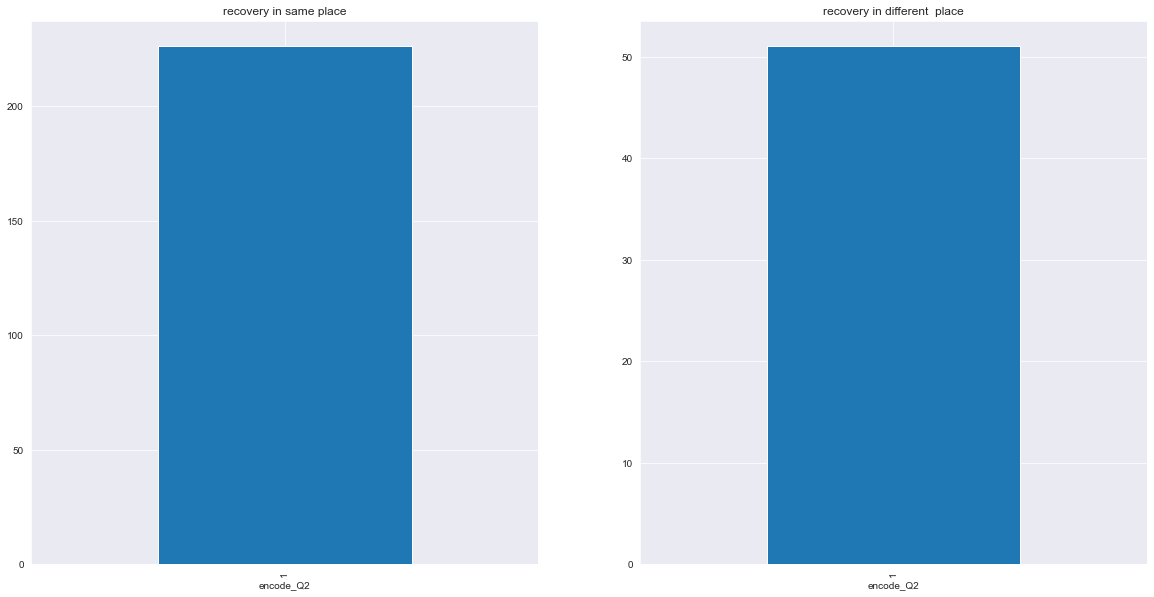

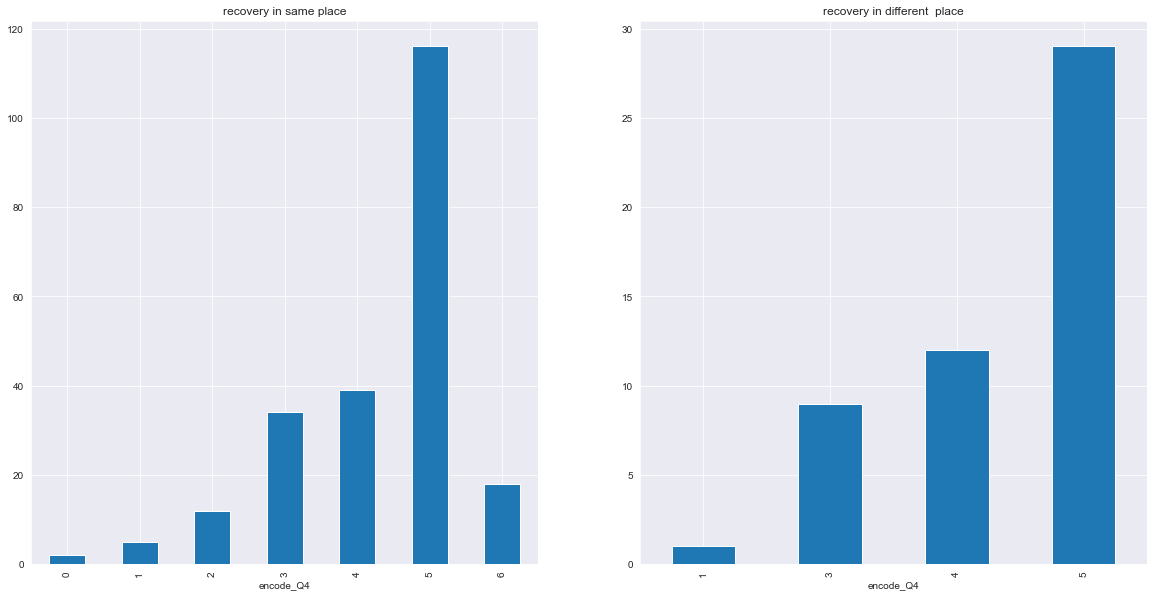

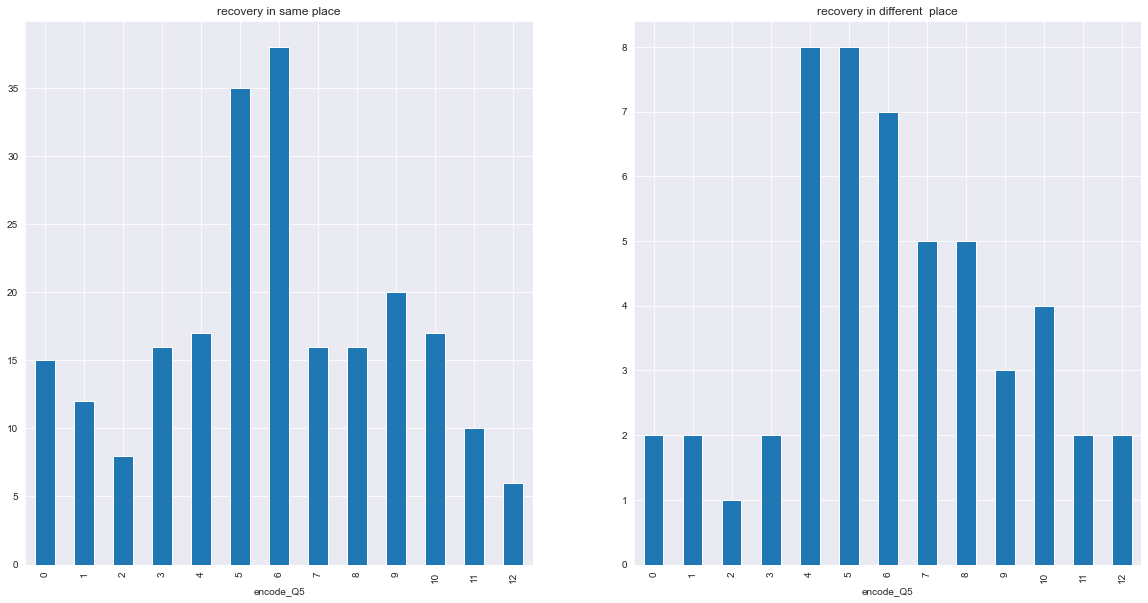

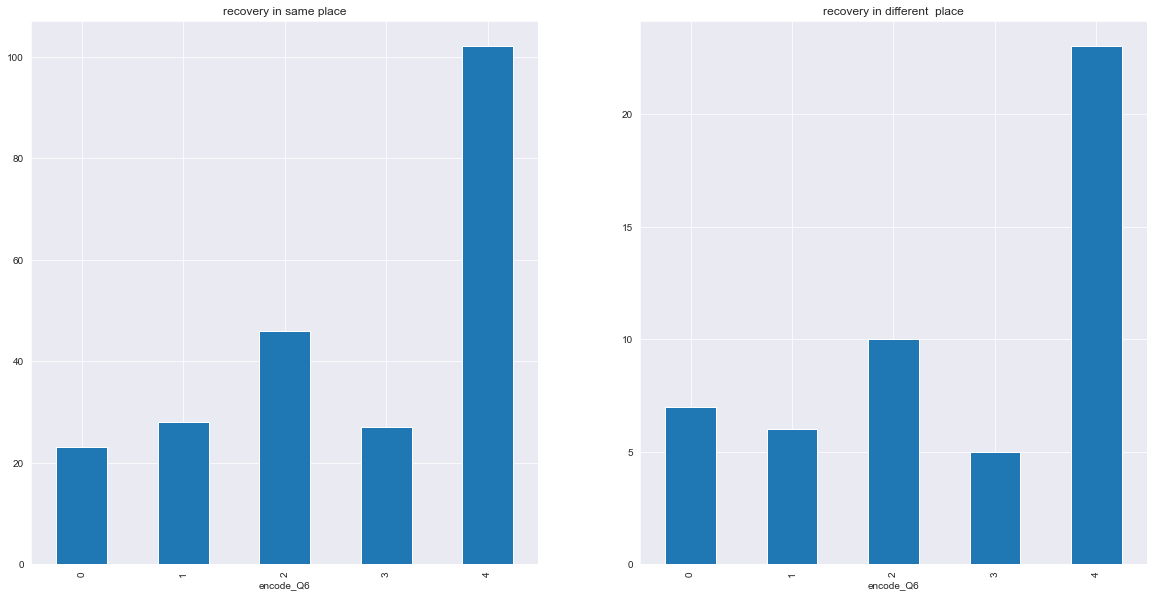

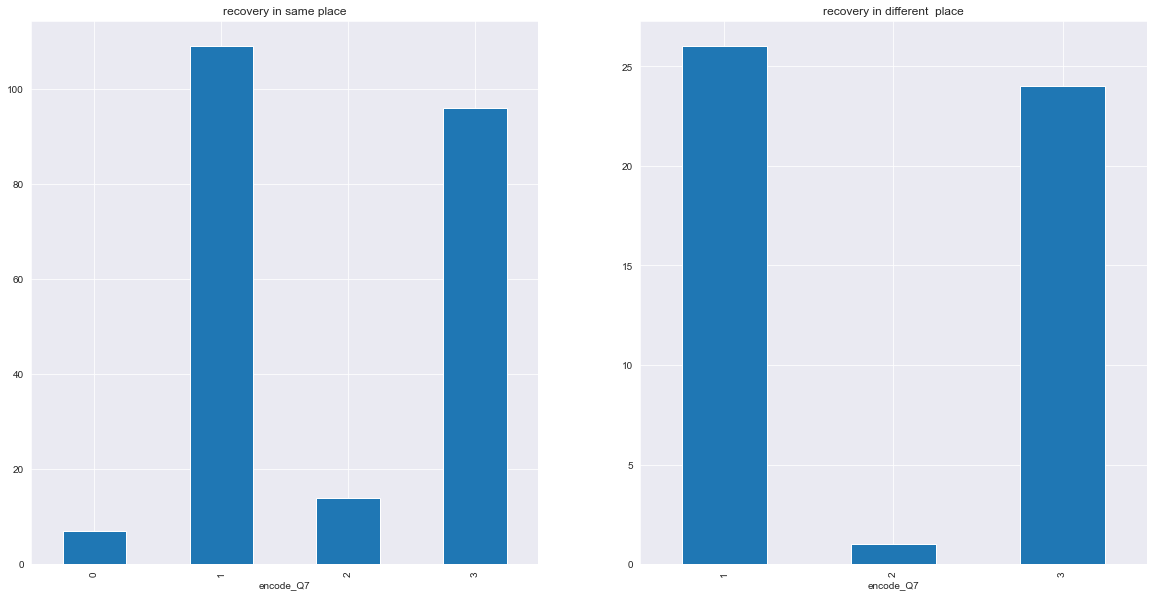

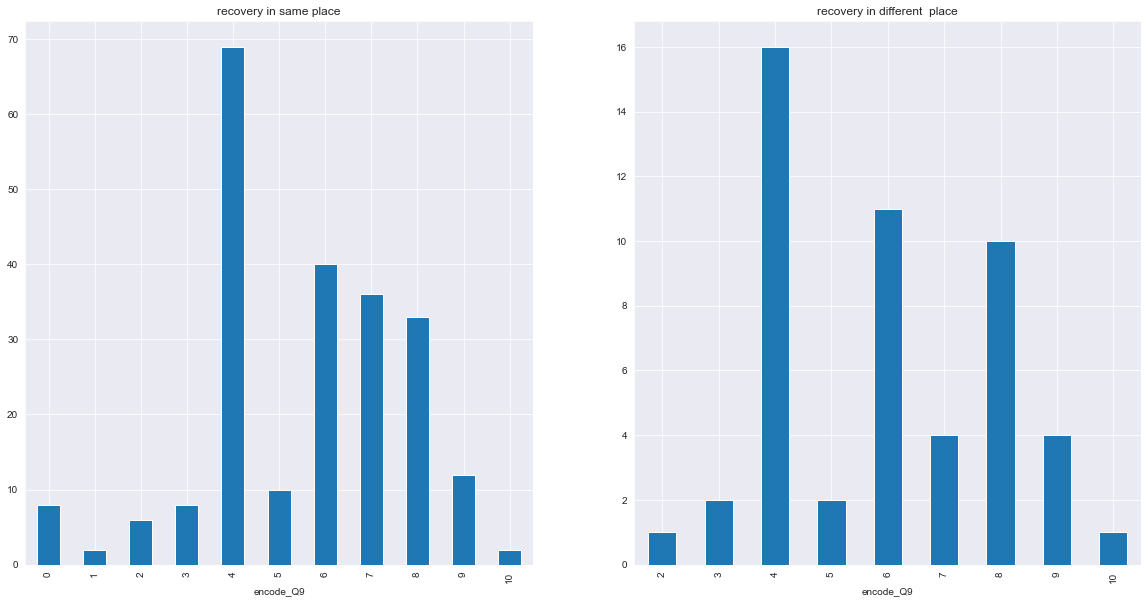

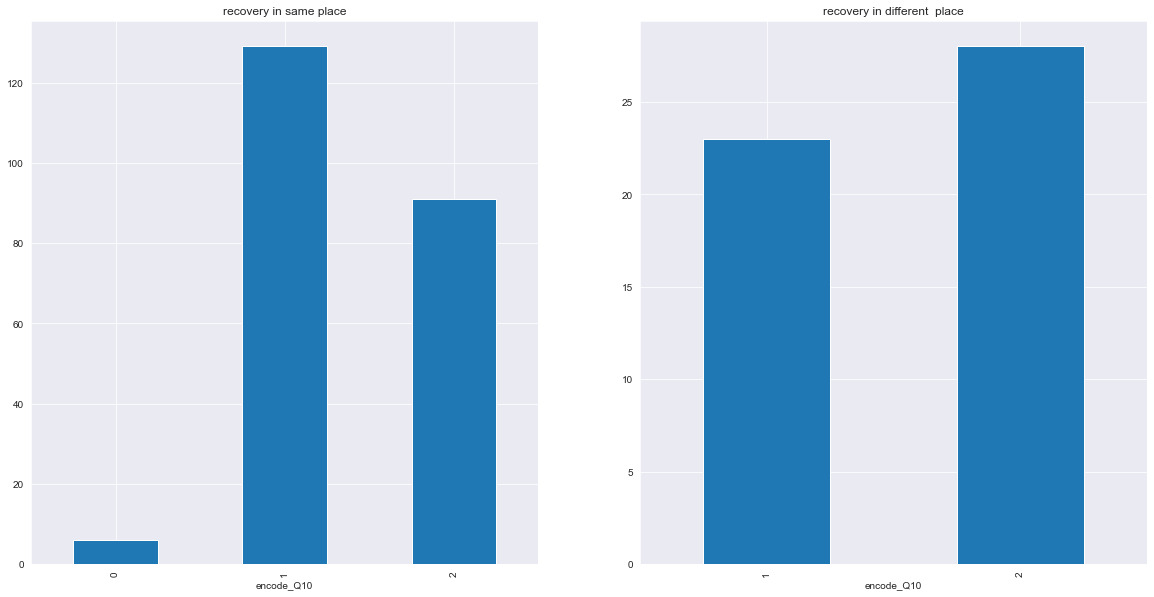

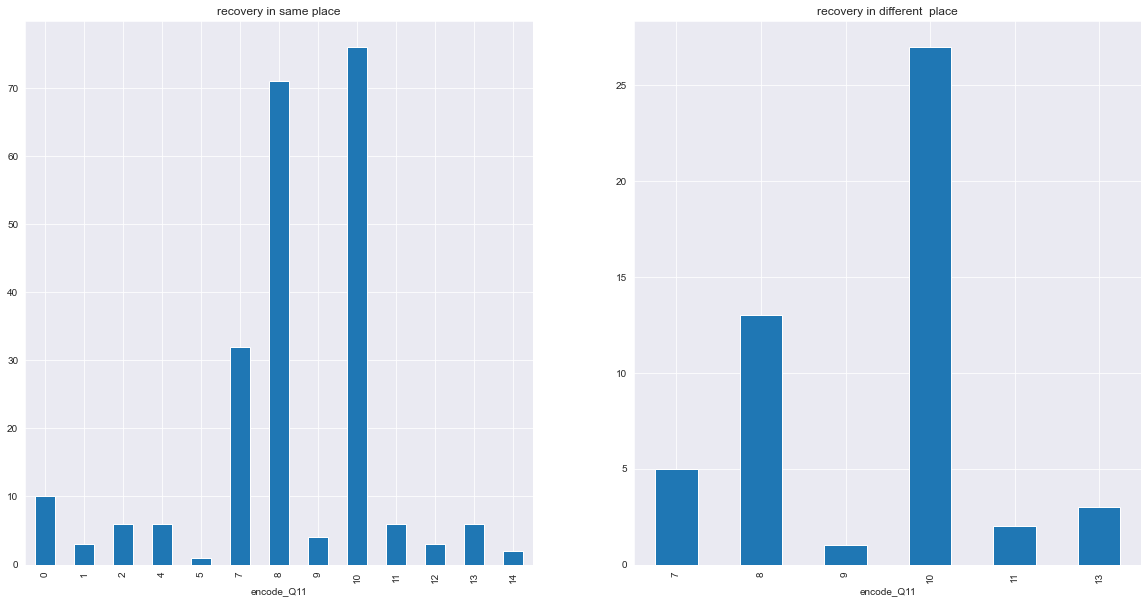

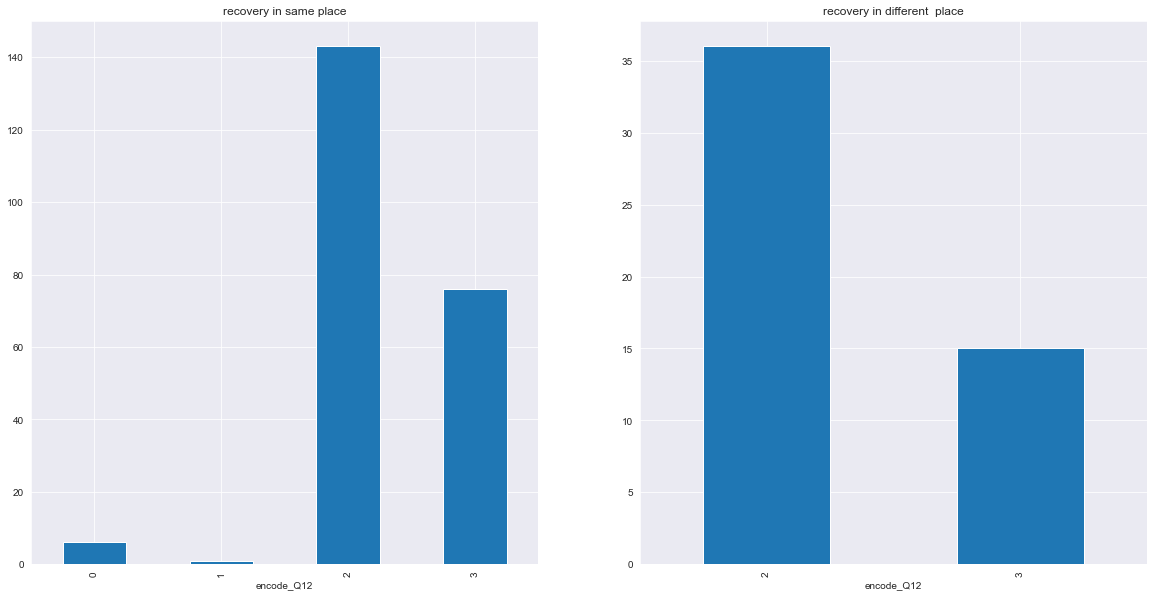

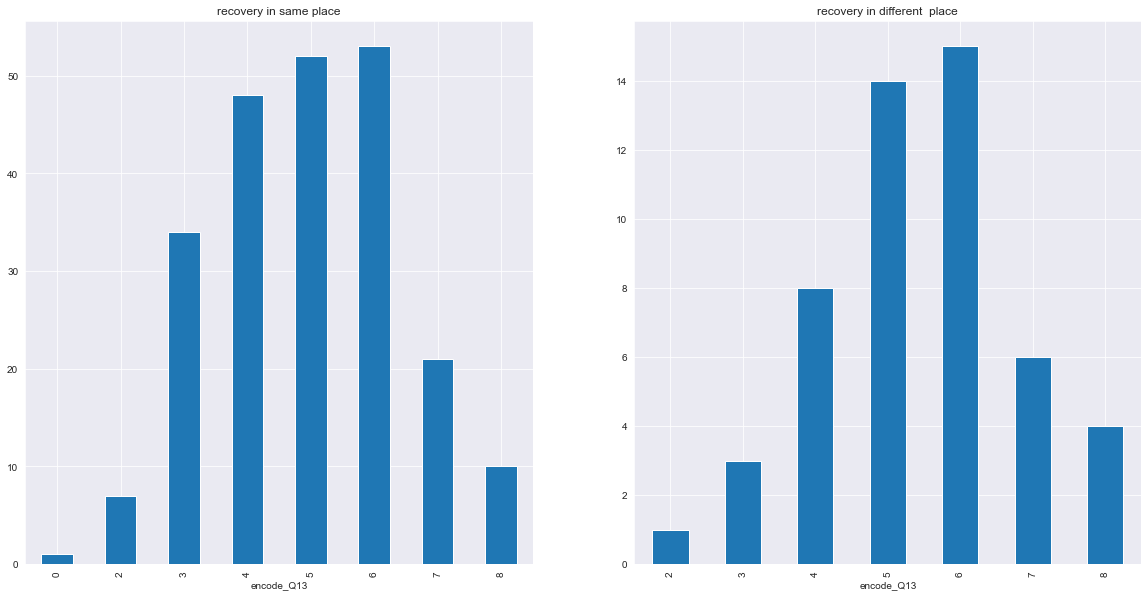

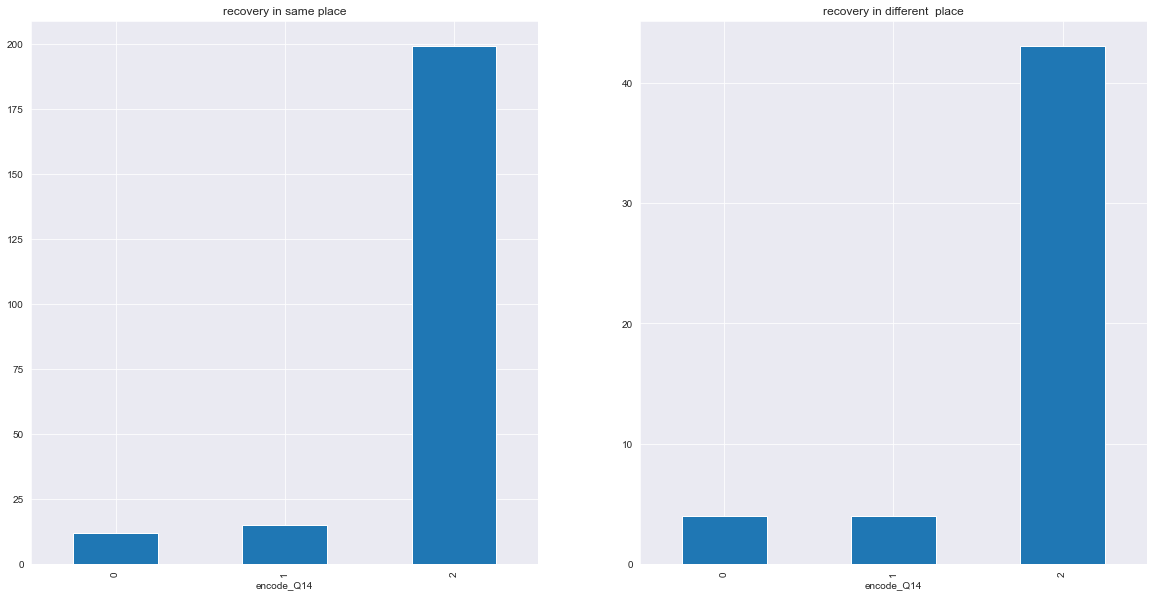

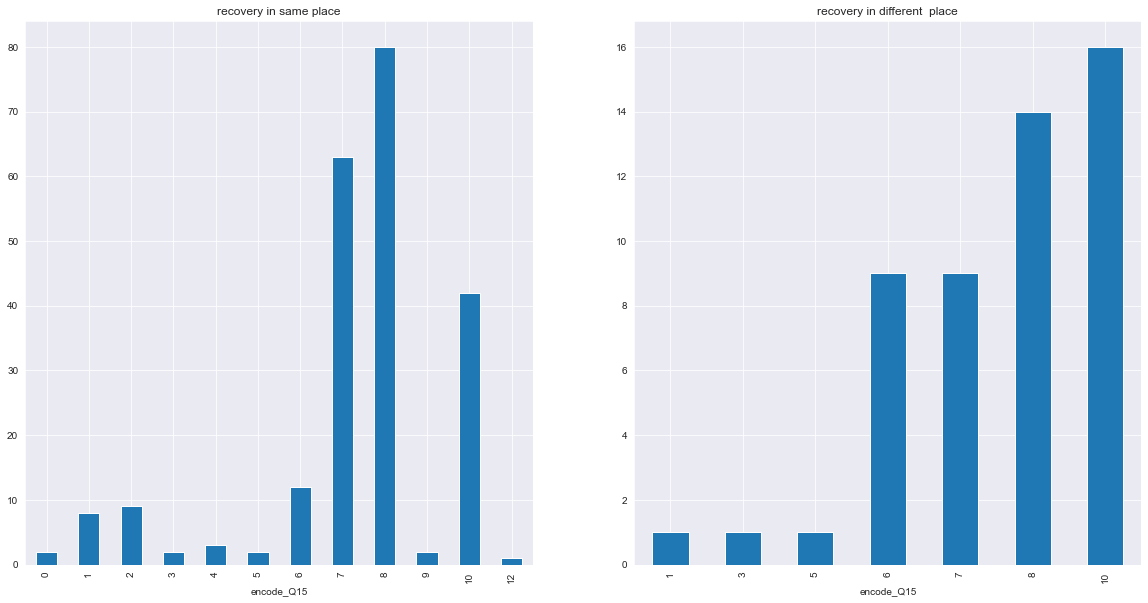

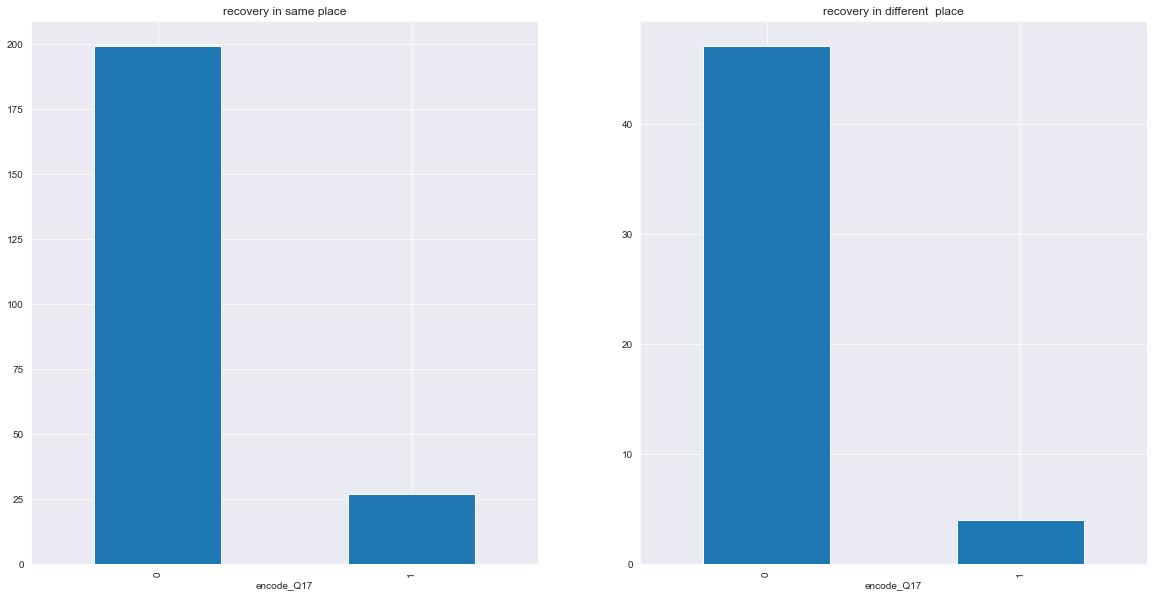

In [30]:

for encode_col in cols_encode.values():
    print(encode_col)
    figure(figsize=(20, 10))
    same.groupby(by=encode_col).count()['index'].plot.bar(ax=plt.subplot(1, 2, 1), title='recovery in same place')
    diff.groupby(by=encode_col).count()['index'].plot.bar(ax=plt.subplot(1, 2, 2), title='recovery in different  place')

In [31]:
same

index                                            Q2    Q4  \
0        4  Entire bicycle (i.e., frame and components)   2022   
1       12  Entire bicycle (i.e., frame and components)    NaN   
2       15  Entire bicycle (i.e., frame and components)   2022   
3       18  Entire bicycle (i.e., frame and components)   2022   
4       20  Entire bicycle (i.e., frame and components)   2021   
..     ...                                           ...   ...   
275   1975  Entire bicycle (i.e., frame and components)   2020   
276   1976  Entire bicycle (i.e., frame and components)   2022   
277   1986  Entire bicycle (i.e., frame and components)   2017   
278   1988  Entire bicycle (i.e., frame and components)    NaN   
279   2011  Entire bicycle (i.e., frame and components)   2019   

                      Q5                       Q6  \
0                 March   Afternoon (12:00-17:59)   
1    Don’t know/not sure  Overnight (00:00-05:59)   
2                 March     Evening (18:00-23:59)   
3                 March   Overnight (00:00-05:59)   
4                 April     Morning (06:00-11:59)   
..                   ...                      ...   
275             October   Overnight (00:00-05:59)   
276             January   Overnight (00:00-05:59)   
277                 May   Overnight (00:00-05:59)   
278                June   Afternoon (12:00-17:59)   
279                July   Afternoon (12:00-17:59)   

                                                    Q7  \
0    Yes, frame locked to a fixed structure (e.g., ...   
1                                        No, unlocked    
2    Yes, frame locked to a fixed structure (e.g., ...   
3                                        No, unlocked    
4                                        No, unlocked    
..                                                 ...   
275  Yes, frame locked to a fixed structure (e.g., ...   
276  Yes, frame locked to a fixed structure (e.g., ...   
277                                      No, unlocked    
278                                      No, unlocked    
279  Yes, frame locked to a fixed structure (e.g., ...   

                                                    Q9   Q10  \
0                                   Outdoor bike rack   Yes    
1                              Other (please specify):   No    
2                              Other (please specify):  Yes    
3                                Inside a shed/garage    No    
4    Against a street sign, tree, or street furnitu...   No    
..                                                 ...   ...   
275       Parking garage bike rack/railing/pipe/etc.    Yes    
276       Parking garage bike rack/railing/pipe/etc.     No    
277  Outside in the yard or on a balcony, porch, or...   No    
278  Outside in the yard or on a balcony, porch, or...   No    
279                                  Workplace office    No    

                                                   Q11   Q12  ... encode_Q10  \
0                                          The police   Yes   ...          2   
1    The police ,A bicycle registry/recovery system...   No   ...          1   
2                           I did not report the theft   No   ...          2   
3    The police ,A bicycle registry/recovery system...   No   ...          1   
4                                          The police   Yes   ...          1   
..                                                 ...   ...  ...        ...   
275  A bicycle registry/recovery system (e.g., Bike...   No   ...          2   
276  The police ,Social media (e.g. Instagram, Twit...   No   ...          1   
277                                        The police    No   ...          1   
278                                        The police    No   ...          1   
279  The police ,A bicycle registry/recovery system...   No   ...          1   

    encode_Q11 encode_Q12 encode_Q14  encode_Q15  encode_Q17  encode_Q6  \
0            7          3          2           5           0          2  

In [56]:
same_groupby =same.groupby(by='encode_Q15').count()
merge_same = same_groupby.rename(columns={'index':'same'})['same']
merge_same

encode_Q15
0      2
1      8
2      9
3      2
4      3
5      2
6     12
7     63
8     80
9      2
10    42
12     1
Name: same, dtype: int64

In [55]:
diff_groupby =diff.groupby(by='encode_Q15').count()
merge_diff = diff_groupby.rename(columns={'index':'diff'})['diff']
merge_diff

encode_Q15
1      1
3      1
5      1
6      9
7      9
8     14
10    16
Name: diff, dtype: int64

In [75]:
fo_hi_square_test = merge_same.reset_index().merge(merge_diff.reset_index(),on='encode_Q15',how='outer').fillna(0).set_index('encode_Q15')
fo_hi_square_test['same_rel'] = fo_hi_square_test['same']/fo_hi_square_test['same'].sum()
fo_hi_square_test['diff_rel'] = fo_hi_square_test['diff']/fo_hi_square_test['same'].sum()
final = fo_hi_square_test[['diff_rel','same_rel']].T

In [ ]:
c, p, dof, expected = chi2_contingency(fo_hi_square_test)

In [64]:
c, p, dof, expected

(19.098560566621778,
 0.059347098487715494,
 11,
 array([[ 1.63176895,  7.34296029,  7.34296029,  2.44765343,  2.44765343,
          2.44765343, 17.13357401, 58.74368231, 76.69314079,  1.63176895,
         47.32129964,  0.81588448],
        [ 0.36823105,  1.65703971,  1.65703971,  0.55234657,  0.55234657,
          0.55234657,  3.86642599, 13.25631769, 17.30685921,  0.36823105,
         10.67870036,  0.18411552]]))

In [76]:
c, p, dof, expected = chi2_contingency(final)
c, p, dof, expected

(0.08450690516204326,
 0.9999999999072098,
 11,
 array([[0.00162934, 0.00733203, 0.00733203, 0.00244401, 0.00244401,
         0.00244401, 0.01710808, 0.05865627, 0.07657902, 0.00162934,
         0.04725089, 0.00081467],
        [0.00722022, 0.03249097, 0.03249097, 0.01083032, 0.01083032,
         0.01083032, 0.07581227, 0.2599278 , 0.33935018, 0.00722022,
         0.20938628, 0.00361011]]))